In [4]:
import ee
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2
from skimage.metrics import mean_squared_error

Etape 0 : Affichage de l'image satellitaire

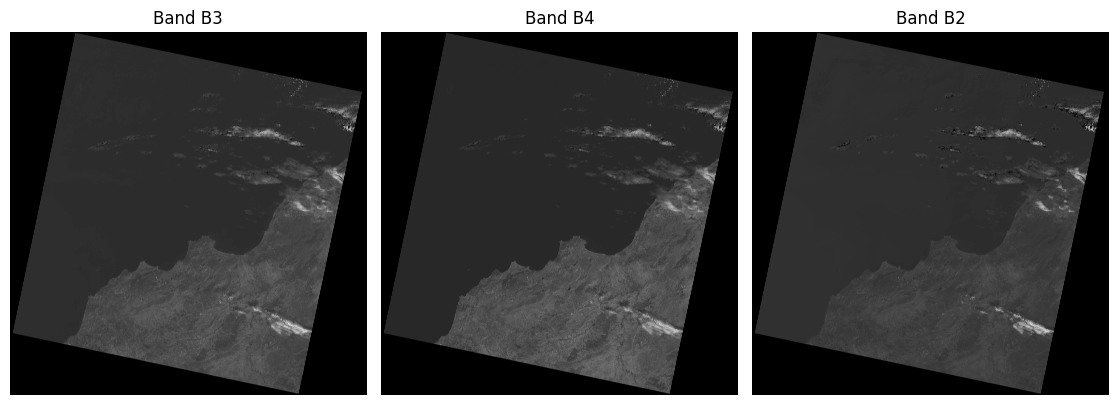

In [5]:
band_paths = {
    'B3': 'images/LC08_L2SP_198035_20240912_20240920_02_T1_SR_B3.TIF',
    'B4': 'images/LC08_L2SP_198035_20240912_20240920_02_T1_SR_B4.TIF',
    'B2': 'images/LC08_L2SP_198035_20240912_20240920_02_T1_SR_B2.TIF'
}
def read_band(band_path):
    with rasterio.open(band_path) as src:
        return src.read(1)

bands = {band_name: read_band(band_path) for band_name, band_path in band_paths.items()}
plt.figure(figsize=(15, 10))
for i, (band_name, band_data) in enumerate(bands.items(), 1):
    plt.subplot(2, 4, i)
    plt.imshow(band_data, cmap='gray')
    plt.title(f'Band {band_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

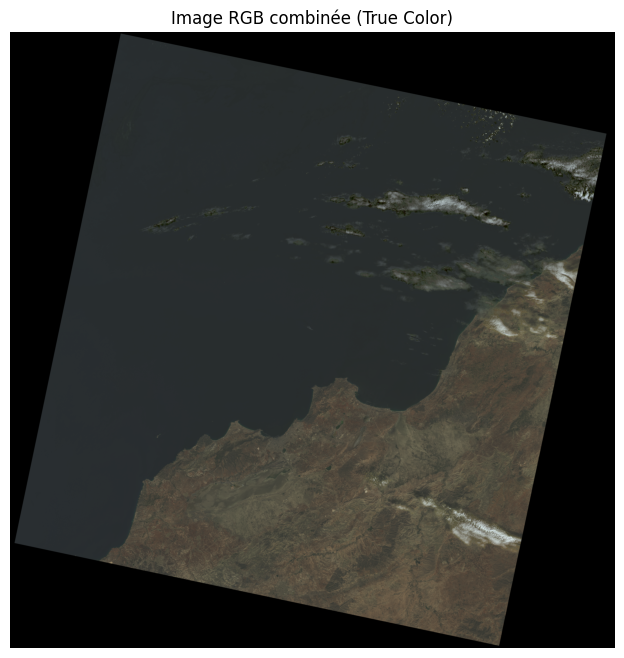

In [6]:
def normalize(band):
    return (band - np.min(band)) / (np.max(band) - np.min(band))
red = normalize(bands['B4'])    
green = normalize(bands['B3'])  
blue = normalize(bands['B2'])   
rgb = np.dstack((red, green, blue))
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title('Image RGB combinée (True Color)')
plt.axis('off')
plt.show()

In [7]:
rgb = np.dstack((red, green, blue))
rgb_image = (rgb * 255).astype(np.uint8)  
pil_image = Image.fromarray(rgb_image)
pil_image.save('images/image_combinée_simple(true_color).tiff')
with rasterio.open('images/image_combinée_simple(true_color).tiff') as src:
    img = src.read([1, 2, 3])
    img = np.dstack(img) 
height, width, _ = img.shape
print(f"Dimensions de l'image : {width}x{height}")

c:\Users\M\AppData\Local\Programs\Python\Python311\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Dimensions de l'image : 7581x7721


Etape 1 : Opération géométrique

In [8]:
x = 1500  
y = 5400 
t1 = 400  
t2 = 400 

In [9]:
def cutimage(x, y, t1, t2, img, output_path):
    cut_img = img[y:y+t2, x:x+t1, :]
    cut_img_pil = Image.fromarray(cut_img)
    cut_img_pil.save(output_path)
    print(f"Zone découpée et enregistrée sous {output_path}")

cutimage(x, y, t1, t2, img, 'images/zone_decoupee.tiff')
height, width, _ = img.shape
print(f"Dimensions de l'image : {width}x{height}")

if (x + t1 <= width) and (y + t2 <= height):
    cutimage(x, y, t1, t2, img, 'Output_images/output_path.tiff')
else:
    print("Les coordonnées de découpe dépassent les dimensions de l'image.")

Zone découpée et enregistrée sous images/zone_decoupee.tiff
Dimensions de l'image : 7581x7721
Zone découpée et enregistrée sous Output_images/output_path.tiff


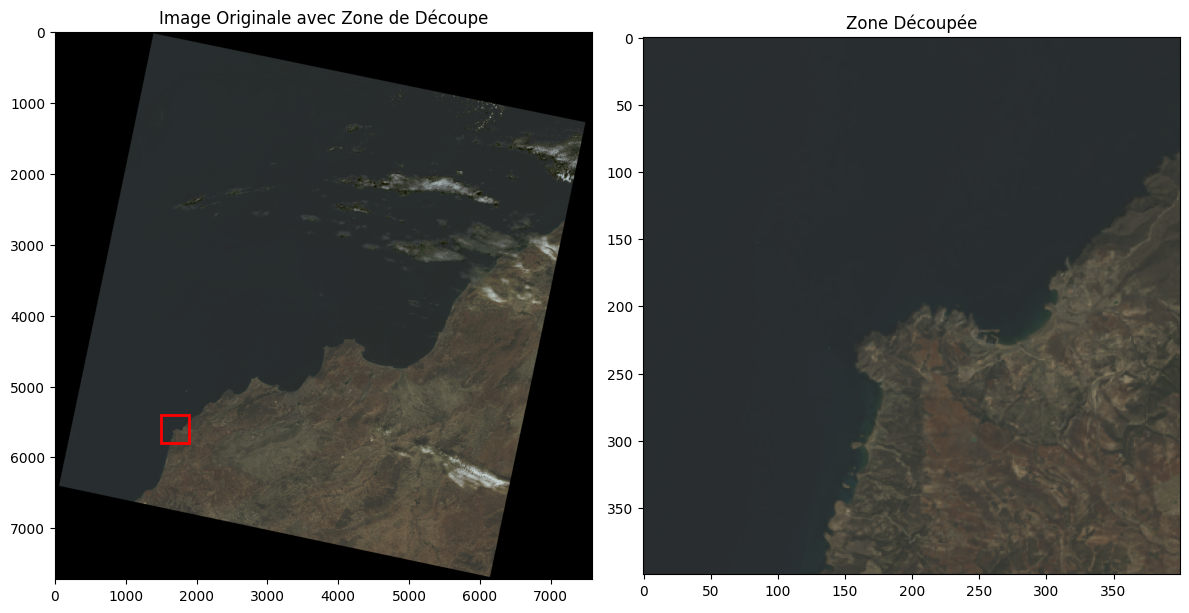

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img)
rect = plt.Rectangle((x, y), t1, t2, linewidth=2, edgecolor='r', facecolor='none')
axs[0].add_patch(rect)
axs[0].set_title("Image Originale avec Zone de Découpe")
decoupee = np.array(Image.open('Output_images/output_path.png'))
axs[1].imshow(decoupee)
axs[1].set_title("Zone Découpée")
plt.tight_layout()  
plt.show()

Etape 2 : Compression

In [11]:
decoupee = Image.open('Output_images/output_path.png')

# Définir le dossier de sortie
output_folder = 'Output_images'

# S'assurer que le dossier de sortie existe
os.makedirs(output_folder, exist_ok=True)

# Sauvegarder sous différents formats
formats = ['bmp', 'jpeg', 'gif', 'tiff']
output_paths = []

for fmt in formats:
    output_file = os.path.join(output_folder, f'output_path.{fmt}')
    decoupee.save(output_file)
    output_paths.append(output_file)
    print(f"Image sauvegardée sous {fmt} : {output_file}")

# Afficher la taille de chaque fichier
for output_file in output_paths:
    file_size = os.path.getsize(output_file)
    print(f"Taille de {output_file} : {file_size / 1024:.2f} KB")

Image sauvegardée sous bmp : Output_images\output_path.bmp
Image sauvegardée sous jpeg : Output_images\output_path.jpeg
Image sauvegardée sous gif : Output_images\output_path.gif
Image sauvegardée sous tiff : Output_images\output_path.tiff
Taille de Output_images\output_path.bmp : 468.80 KB
Taille de Output_images\output_path.jpeg : 9.34 KB
Taille de Output_images\output_path.gif : 88.81 KB
Taille de Output_images\output_path.tiff : 468.89 KB


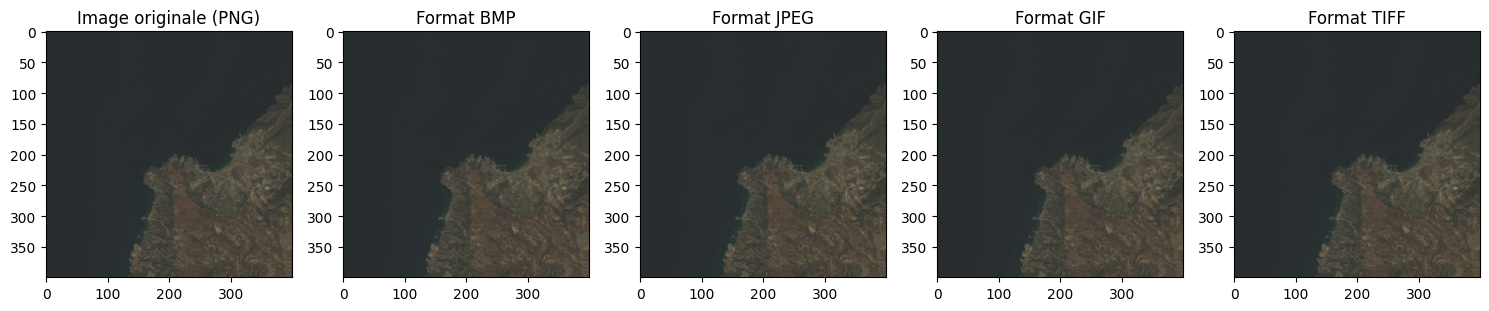

In [12]:
fig, axs = plt.subplots(1, len(formats) + 1, figsize=(15, 5))


axs[0].imshow(np.array(decoupee))
axs[0].set_title("Image originale (PNG)")
for i, fmt in enumerate(formats):
    img_compressed = Image.open(f'Output_images/output_path.{fmt}')
    
    if fmt == 'gif':
        img_compressed = img_compressed.convert("RGB")
        
    axs[i + 1].imshow(np.array(img_compressed))
    axs[i + 1].set_title(f"Format {fmt.upper()}")

plt.tight_layout()
plt.show()

In [13]:
#Fonction Prédefinie
def eqm_sklearn(img_source, img_result):
    """Calcule l'erreur quadratique moyenne entre deux images avec sklearn."""
    img_source_array = np.array(img_source)
    img_result_array = np.array(img_result)
    if img_source_array.shape != img_result_array.shape:
        raise ValueError("Les dimensions des images doivent être identiques.")
    return mean_squared_error(img_source_array.flatten(), img_result_array.flatten())

def eqm_manual(img_source, img_result):
    """Calcule l'erreur quadratique moyenne entre deux images avec une approche manuelle."""
    img1_array = np.array(img_source)
    img2_array = np.array(img_result)
    
    if img1_array.shape != img2_array.shape:
        raise ValueError("Les images doivent avoir les mêmes dimensions pour calculer l'EQM.")
    eqm_value = np.sum((img1_array.astype(float) - img2_array.astype(float)) ** 2) / img1_array.size
    
    return eqm_value

# Fonction de comparaison des deux résultats
def comparer_eqm(original_image_path, formats=['bmp', 'jpeg', 'gif', 'tiff']):
    original = Image.open(original_image_path)
    original_rgb = original.convert('RGB')
    for fmt in formats:
        try:
            compressed_image = Image.open(f'Output_images/output_path.{fmt}')
            compressed_rgb = compressed_image.convert('RGB')
            compressed_rgb = compressed_rgb.resize(original_rgb.size)
            eqm_value_sklearn = eqm_sklearn(original_rgb, compressed_rgb)
            eqm_value_manual = eqm_manual(original_rgb, compressed_rgb)
            
            # Comparer les résultats
            print(f"Format {fmt.upper()}:")
            print(f"  EQM (sklearn) : {eqm_value_sklearn:.4f}")
            print(f"  EQM (manuel)  : {eqm_value_manual:.4f}")
            print(f"  Différence    : {abs(eqm_value_sklearn - eqm_value_manual):.4f}\n")
        except FileNotFoundError:
            print(f"Erreur : L'image compressée '{fmt}' n'a pas été trouvée.")
        except Exception as e:
            print(f"Une erreur s'est produite avec le format {fmt.upper()}: {e}")
comparer_eqm('Output_images/output_path.png')


Format BMP:
  EQM (sklearn) : 0.0000
  EQM (manuel)  : 0.0000
  Différence    : 0.0000

Format JPEG:
  EQM (sklearn) : 4.2663
  EQM (manuel)  : 4.2663
  Différence    : 0.0000

Format GIF:
  EQM (sklearn) : 0.2997
  EQM (manuel)  : 0.2997
  Différence    : 0.0000

Format TIFF:
  EQM (sklearn) : 0.0000
  EQM (manuel)  : 0.0000
  Différence    : 0.0000



 Etape 3 : Rehaussement de contraste

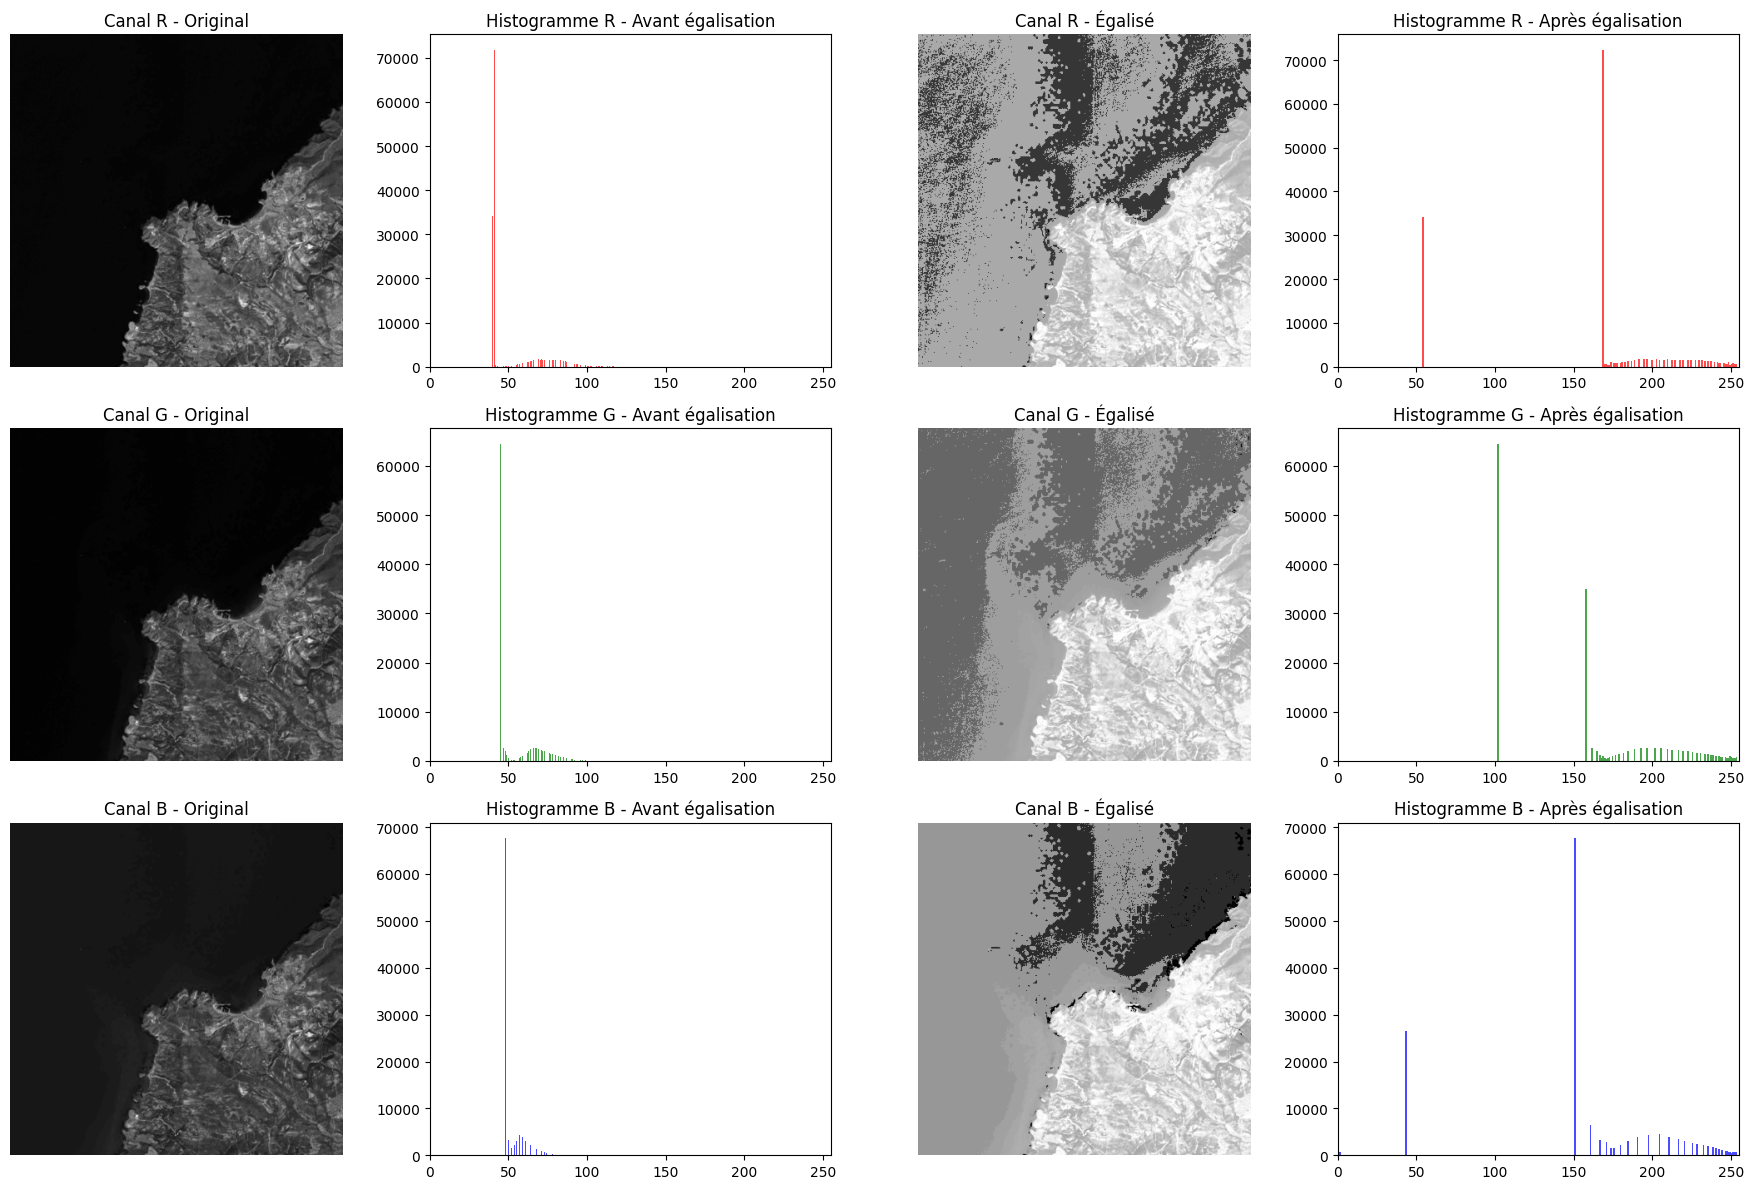

EQM entre l'image originale et l'image égalisée : 88.23751875


In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def histogram_equalization(image_channel):
    hist, bins = np.histogram(image_channel.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8') 
    return cdf_final[image_channel]

def eqm_manual(img_source, img_result):
    img1_array = np.array(img_source)
    img2_array = np.array(img_result)
    
    if img1_array.shape != img2_array.shape:
        raise ValueError("Les images doivent avoir les mêmes dimensions pour calculer l'EQM.")
    eqm_value = np.mean((img1_array - img2_array) ** 2)
    return eqm_value

# Charger l'image et convertir en RGB
img = Image.open('Output_images/output_path.png')
img = img.convert('RGB') 
r, g, b = img.split()

# Appliquer l'égalisation d'histogramme sur chaque canal
r_eq = histogram_equalization(np.array(r))
g_eq = histogram_equalization(np.array(g))
b_eq = histogram_equalization(np.array(b))
img_equalized = Image.merge('RGB', (Image.fromarray(r_eq), Image.fromarray(g_eq), Image.fromarray(b_eq)))

# Calculer l'EQM entre l'image originale et l'image égalisée
eqm_global = eqm_manual(np.array(img), np.array(img_equalized))

# Afficher chaque canal et son histogramme avant et après égalisation
fig, axs = plt.subplots(3, 4, figsize=(18, 12))
channels = {'R': (r, r_eq, 'red'), 'G': (g, g_eq, 'green'), 'B': (b, b_eq, 'blue')}

for i, (color, (channel, channel_eq, col)) in enumerate(channels.items()):
    # Afficher l'image du canal original en niveaux de gris
    axs[i, 0].imshow(channel, cmap='gray')
    axs[i, 0].set_title(f'Canal {color} - Original')
    axs[i, 0].axis('off')
    
    # Histogramme du canal original
    axs[i, 1].hist(np.array(channel).flatten(), bins=256, color=col, alpha=0.7)
    axs[i, 1].set_title(f'Histogramme {color} - Avant égalisation')
    axs[i, 1].set_xlim(0, 255)
    
    # Afficher l'image du canal égalisé en niveaux de gris
    axs[i, 2].imshow(channel_eq, cmap='gray')
    axs[i, 2].set_title(f'Canal {color} - Égalisé')
    axs[i, 2].axis('off')
    
    # Histogramme du canal égalisé
    axs[i, 3].hist(channel_eq.flatten(), bins=256, color=col, alpha=0.7)
    axs[i, 3].set_title(f'Histogramme {color} - Après égalisation')
    axs[i, 3].set_xlim(0, 255)

plt.tight_layout()
plt.show()

print(f"EQM entre l'image originale et l'image égalisée : {eqm_global}")


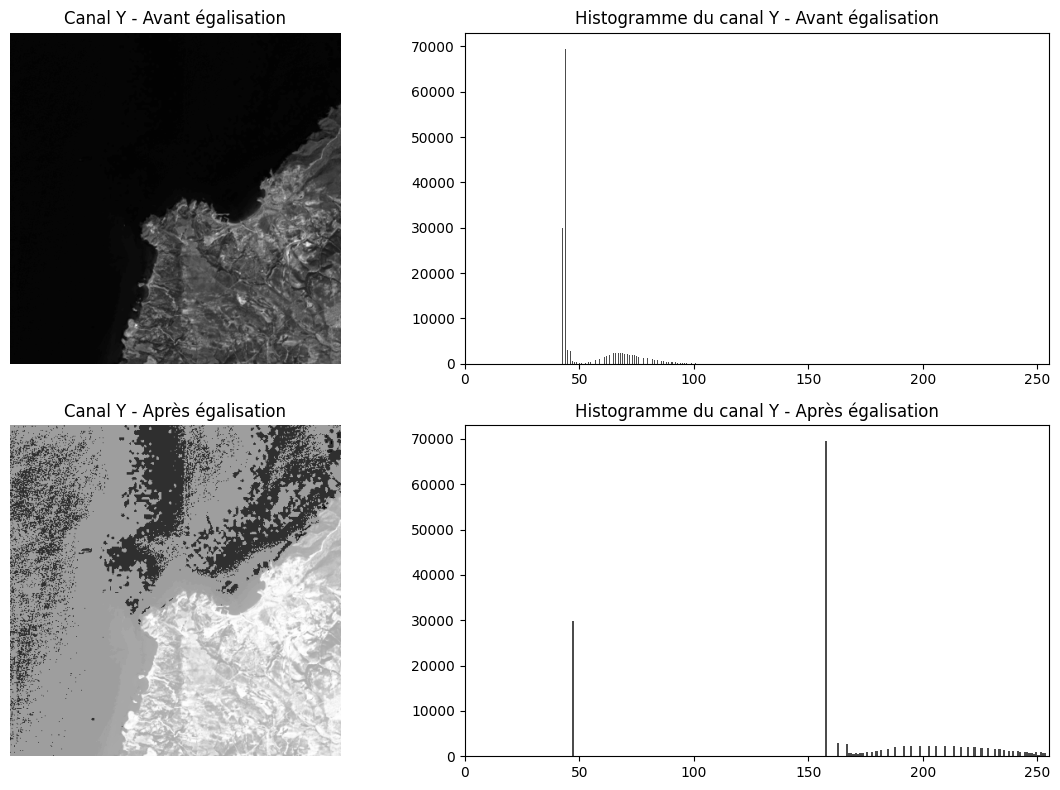

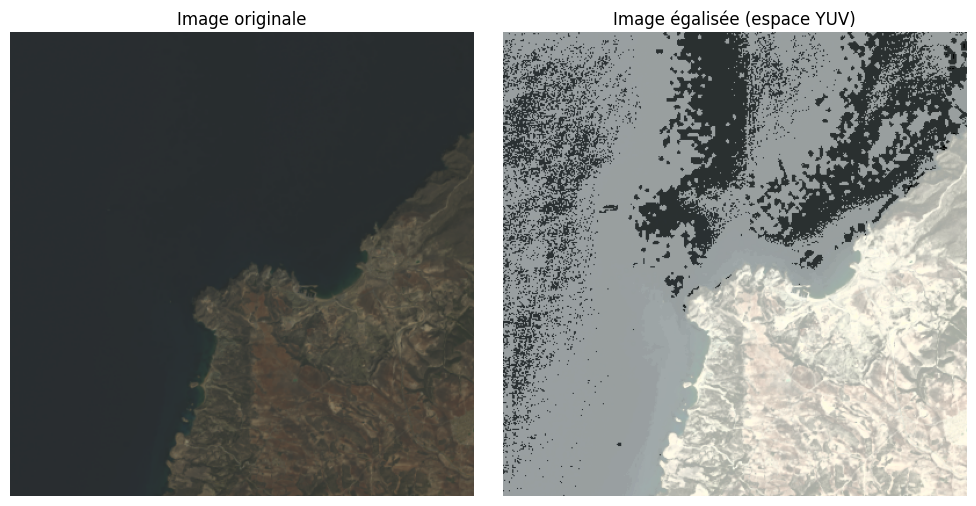

In [15]:

def histogram_equalization(image_channel):
    hist, bins = np.histogram(image_channel.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8') 
    return cdf_final[image_channel]

def equalize_rgb_using_yuv(image):
    img_yuv = np.array(image.convert('YCbCr'))  # Convertir en YUV
    y_channel, u, v = img_yuv[:, :, 0], img_yuv[:, :, 1], img_yuv[:, :, 2]
    
    # Appliquer l'égalisation d'histogramme au canal Y
    y_eq = histogram_equalization(y_channel)
    
    # Reconstituer l'image égalisée en YUV puis la convertir en RGB
    img_yuv_eq = np.stack((y_eq, u, v), axis=2)
    img_equalized = Image.fromarray(img_yuv_eq, 'YCbCr').convert('RGB')
    
    return img_equalized, y_channel, y_eq

# Charger l'image et convertir en RGB
img = Image.open('Output_images/output_path.png').convert('RGB')

# Appliquer l'égalisation dans l'espace YUV
img_equalized_yuv, y_original, y_eq = equalize_rgb_using_yuv(img)

# Afficher l'image originale et l'image égalisée en YUV
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Afficher le canal Y original et son histogramme
axs[0, 0].imshow(y_original, cmap='gray')
axs[0, 0].set_title("Canal Y - Avant égalisation")
axs[0, 0].axis('off')

axs[0, 1].hist(y_original.flatten(), bins=256, color='black', alpha=0.7)
axs[0, 1].set_title("Histogramme du canal Y - Avant égalisation")
axs[0, 1].set_xlim(0, 255)

# Afficher le canal Y égalisé et son histogramme
axs[1, 0].imshow(y_eq, cmap='gray')
axs[1, 0].set_title("Canal Y - Après égalisation")
axs[1, 0].axis('off')

axs[1, 1].hist(y_eq.flatten(), bins=256, color='black', alpha=0.7)
axs[1, 1].set_title("Histogramme du canal Y - Après égalisation")
axs[1, 1].set_xlim(0, 255)

plt.tight_layout()
plt.show()

# Afficher les images complètes en RGB pour comparaison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image originale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_equalized_yuv)
plt.title("Image égalisée (espace YUV)")
plt.axis('off')

plt.tight_layout()
plt.show()

Etape 4 : Reduction du bruit

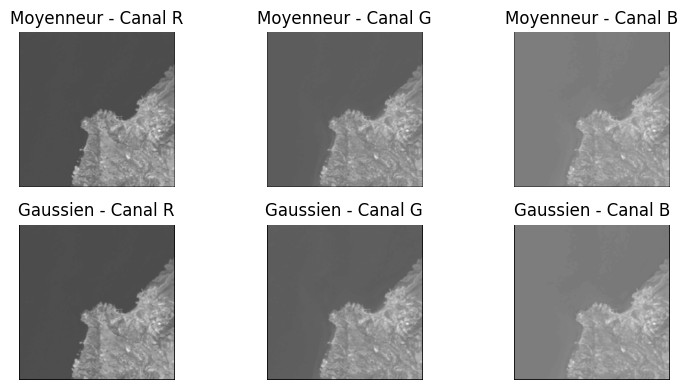

In [31]:
def filtre_moyenneur(img, taille=3):
    M, N = img.shape
    img_lissée = np.zeros_like(img)
    k = taille // 2
    for i in range(k, M-k):
        for j in range(k, N-k):
            img_lissée[i, j] = np.mean(img[i-k:i+k+1, j-k:j+k+1])
    return img_lissée
def filtre_gaussien(img, sigma=1, taille=5):
    def gauss(x, y, sigma):
        return (1.0 / (2.0 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    k = taille // 2
    gauss_mask = np.zeros((taille, taille))
    for x in range(-k, k+1):
        for y in range(-k, k+1):
            gauss_mask[x+k, y+k] = gauss(x, y, sigma)
    gauss_mask /= np.sum(gauss_mask)  
    M, N = img.shape
    img_lissée = np.zeros_like(img)
    for i in range(k, M-k):
        for j in range(k, N-k):
            img_lissée[i, j] = np.sum(img[i-k:i+k+1, j-k:j+k+1] * gauss_mask)
    return img_lissée
img = np.array(Image.open('Output_images/output_path.png'))
filtered_mean_channels = [filtre_moyenneur(img[:,:,c]) for c in range(3)]
filtered_gaussian_channels = [filtre_gaussien(img[:,:,c]) for c in range(3)]
fig, axs = plt.subplots(2, 3, figsize=(8, 4))  
for i, (mean_img, gaussian_img) in enumerate(zip(filtered_mean_channels, filtered_gaussian_channels)):
    axs[0, i].imshow(mean_img, cmap='gray')
    axs[0, i].set_title(f"Moyenneur - Canal {'RGB'[i]}")
    axs[0, i].axis('off')
    
    axs[1, i].imshow(gaussian_img, cmap='gray')
    axs[1, i].set_title(f"Gaussien - Canal {'RGB'[i]}")
    axs[1, i].axis('off')
plt.tight_layout()
plt.show()


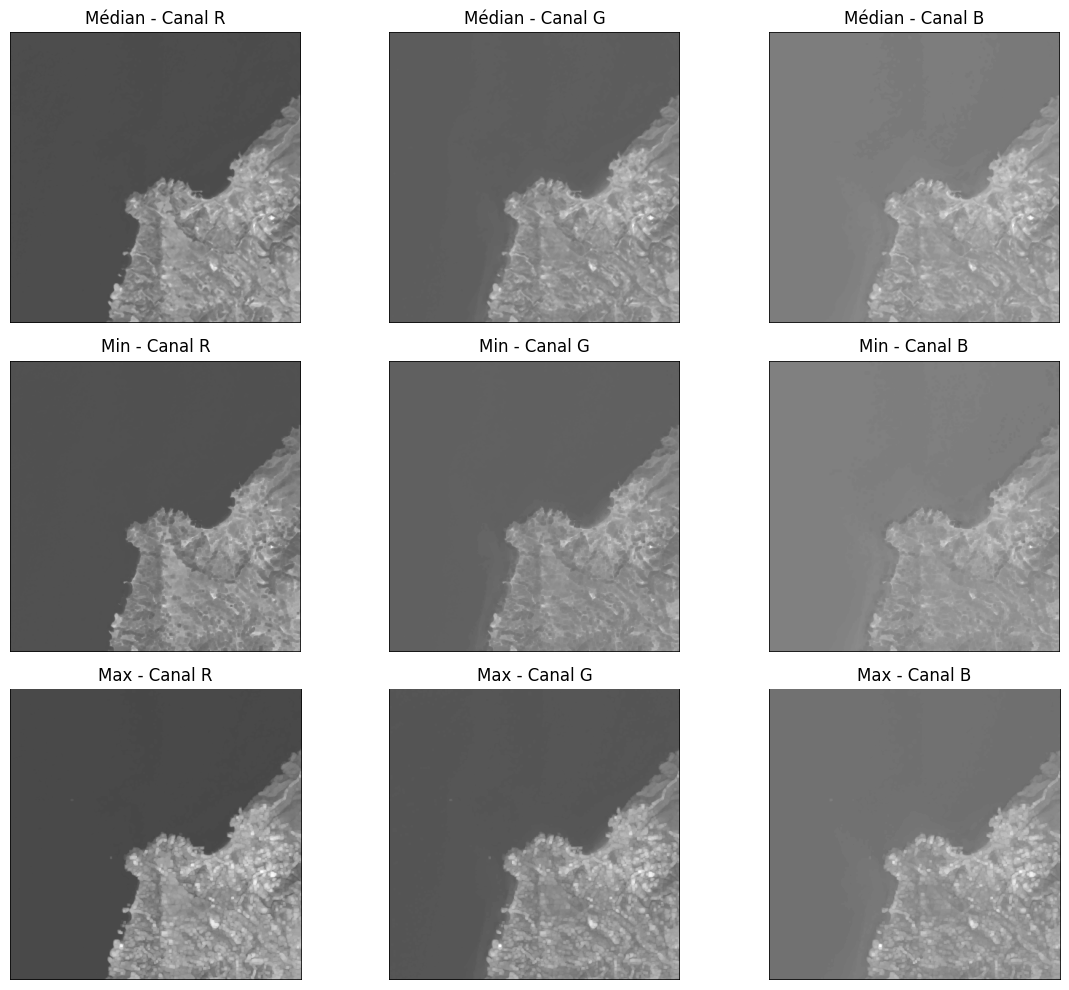

In [35]:
# Filtre médian
def filtre_median(img, taille=3):
    M, N = img.shape
    img_lissée = np.zeros_like(img)
    k = taille // 2
    for i in range(k, M-k):
        for j in range(k, N-k):
            img_lissée[i, j] = np.median(img[i-k:i+k+1, j-k:j+k+1])
    return img_lissée
# Filtre min/max
def filtre_min_max(img, taille=3, mode='min'):
    M, N = img.shape
    img_lissée = np.zeros_like(img)
    k = taille // 2
    for i in range(k, M-k):
        for j in range(k, N-k):
            if mode == 'min':
                img_lissée[i, j] = np.min(img[i-k:i+k+1, j-k:j+k+1])
            elif mode == 'max':
                img_lissée[i, j] = np.max(img[i-k:i+k+1, j-k:j+k+1])
    return img_lissée
img = np.array(Image.open('Output_images/output_path.png'))
filtered_median_channels = [filtre_median(img[:,:,c]) for c in range(3)]
filtered_min_channels = [filtre_min_max(img[:,:,c], mode='min') for c in range(3)]
filtered_max_channels = [filtre_min_max(img[:,:,c], mode='max') for c in range(3)]
fig, axs = plt.subplots(3, 3, figsize=(12, 10))  

# Affichage des filtres médian
for i, median_img in enumerate(filtered_median_channels):
    axs[0, i].imshow(median_img, cmap='gray')
    axs[0, i].set_title(f"Médian - Canal {'RGB'[i]}")
    axs[0, i].axis('off')

# Affichage des filtres min
for i, min_img in enumerate(filtered_min_channels):
    axs[1, i].imshow(min_img, cmap='gray')
    axs[1, i].set_title(f"Min - Canal {'RGB'[i]}")
    axs[1, i].axis('off')

# Affichage des filtres max
for i, max_img in enumerate(filtered_max_channels):
    axs[2, i].imshow(max_img, cmap='gray')
    axs[2, i].set_title(f"Max - Canal {'RGB'[i]}")
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()